In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.000001
opt = tf.keras.optimizers.Adam(lr)
ver = '05' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/HGG/'

---

# Helper Functions

In [3]:
def dice_coef(y_true, y_pred, smooth=1e-5):
    '''
    Dice coefficient for tensorflow
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: dice coefficient 
    '''
    #if input is not flatten
    if (tf.rank(y_true)!=1 and tf.rank(y_pred)!=1):
        y_true = tf.reshape(y_true, [-1]) #flatten 
        y_pred = tf.reshape(y_pred, [-1]) #flatten
    #casting for label from int32 to float32 for computation
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / \
(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def ss_metric(y_true, y_pred, label_type = 'binary', mode = 'global', smooth=1e-5):
    '''
    Compute sensitivity and specificity for groundtruth and prediction
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :label_type: 'binary': input labels is binarized
                 'multi': mutli class labels
    :mode: 'local' compute the sensitivity label wise
           'global' compute the sensitivity overall
    :return: sensitivity & specificity 
    '''
    #if input is not flatten
    if (tf.rank(y_true)!=1 and tf.rank(y_pred)!=1):
        y_true = tf.reshape(y_true, [-1]) #flatten 
        y_pred = tf.reshape(y_pred, [-1]) #flatten
    #label types    
    if label_type =='binary':
        tn, fp, fn, tp = confusion_matrix(y_true , y_pred, labels = [0,1]).ravel()
        sensitivity = (tp+smooth)/(tp+fn+smooth)
        specificity = (tn+smooth)/(tn+fp+smooth)
    if label_type =='multi':
        cm = confusion_matrix(y_true , y_pred, labels = [0,1,2,3])
        #true positive rate 
        if mode=='global':
            tp = np.trace(cm)
            tp_fn = np.sum(cm)
        else: #local
            tp = np.diag(cm)
            tp_fn = np.sum(cm,1)
        sensitivity = (tp+smooth)/(tp_fn+smooth)
        #true negative rate
        diag = np.diag(cm)
        tn = []
        for i in range(len(cm)):
            negs = np.sum([neg for neg in diag if neg!=diag[i]]) 
            tn.append(negs)
        cm_copy = cm
        #make diagonal 0
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i==j:
                    cm_copy[i,j]=0
        if mode=='global':
            tn = np.sum(tn)
            fp = np.sum(cm_copy)
        else: #local
            tn = np.array(tn)
            fp = np.sum(cm_copy, 0)
        specificity = (tn+smooth)/(tn+fp+smooth)
    return sensitivity, specificity

def compute_metric(y_true, y_pred, label_type='binary'):
    '''
    This function compute the metrics specify by BraTS competition
    which is dice coefficient, sensitivity, specificity
    :param y_true: Ground truth image
    :param y_pred: Prediction image from the model
    :label_type: 'binary': input labels is binarized
             'multi': mutli class labels
    :return: dice coefficient, sensitivity & specificity list
            with order ['core', 'enhancing', 'complete']
    '''
    y_list = [y_true, y_pred]
    tumours = ['core', 'enhancing', 'complete']
    dc_output = []
    sens_output = []
    spec_output = []
    #compute dice coefficient for each tumour type
    for tumour_type in tumours:
        if label_type =='multi':
            #label 1, 3(4)
            if tumour_type== 'core':
                y_true, y_pred = [np.where(((lbl==1) | (lbl==3)), lbl, 0) for lbl in y_list]
            #label 3(4)
            if tumour_type== 'enhancing':
                y_true, y_pred = [np.where(lbl==3, lbl, 0) for lbl in y_list]
            #label 1,2,3,
            if tumour_type== 'complete':
                y_true, y_pred = [np.where(lbl>=0, lbl, 0) for lbl in y_list]
        if label_type =='binary':
            #label 1, 3(4) =>1
            if tumour_type== 'core':
                y_true, y_pred = [np.where(((lbl==1) | (lbl==3)), 1, 0) for lbl in y_list]
            #label 3(4) =>1
            if tumour_type== 'enhancing':
                y_true, y_pred = [np.where(lbl==3, 1, 0) for lbl in y_list]
            #label 1,2,3 =>1
            if tumour_type== 'complete':
                y_true, y_pred = [np.where(lbl>=0, 1, 0) for lbl in y_list]
        dc_list = []
        sens_list = []
        spec_list = []
        for idx in range(len(y_true)): 
            
            y_true_f= tf.reshape(y_true[idx], [-1]) #flatten 
            y_pred_f = tf.reshape(y_pred[idx], [-1]) #flatten

            dc = dice_coef(y_true_f, y_pred_f)
            sensitivity, specificity = ss_metric(y_true_f, y_pred_f)    
            #store values
            dc_list.append(dc)
            sens_list.append(sensitivity)
            spec_list.append(specificity)
        #output [BATCH_SIZE, tumours_type]
        #taking the mean along the batch axis
        mean_ = lambda x: np.mean(x)
        dc_batch_mean = mean_(dc_list)
        sens_batch_mean = mean_(sens_list)
        spec_batch_mean = mean_(spec_list)
        #append for each tumour type
        dc_output.append(dc_batch_mean)
        sens_output.append(sens_batch_mean)
        spec_output.append(spec_batch_mean)
    #for each list the order is as following=> 'core','enhancing','complete'    
    return dc_output, sens_output, spec_output

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D

def Unet_model(input_layer):
    #downsampling
#     conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
    conv1 = conv_block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4, kernel_initializer=hn)
#     conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    up2 = up(conv6, filters=256, merge=conv3, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    
    up3 = up(conv7, filters=128, merge=conv2, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    
    up4 = up(conv8, filters=64, merge=conv1, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
Unet = Model(input_layer, Unet_model(input_layer))

In [6]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = xent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1




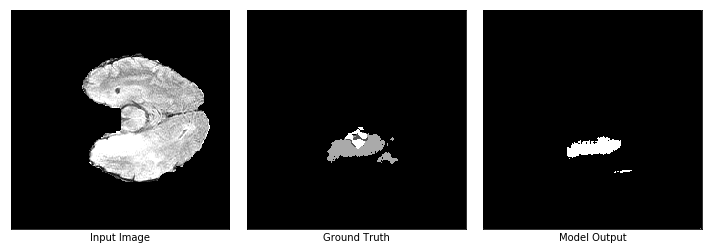

Steps: 2000, Loss:0.1744304895401001
Accurary: 0.9857812523841858
Dice coefficient: 0.9135909080505371
Sensitivity: 0.9920370373688272
Specificity: 0.997168970839562
Gradient min:-0.001915489207021892, max:0.0014569750055670738
-----------<Summary for Epoch:1>------------
Mean Accuracy: 0.9650068283081055
Mean Dice coefficient: 0.36228546500205994
Mean Sensitivity: 0.9794175385239785
Mean Specificity: 0.9877004110903512
------------------------------------------------
Epochs  2




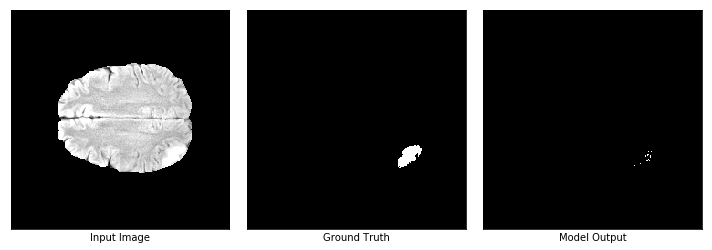

Steps: 2000, Loss:0.04932493716478348
Accurary: 0.9937152862548828
Dice coefficient: 0.9706379175186157
Sensitivity: 0.9979050926798804
Specificity: 0.9992685972277725
Gradient min:-0.001816447009332478, max:0.0021394069772213697
-----------<Summary for Epoch:2>------------
Mean Accuracy: 0.9786843657493591
Mean Dice coefficient: 0.5744511485099792
Mean Sensitivity: 0.9871642446988625
Mean Specificity: 0.9929879794035598
------------------------------------------------
Epochs  3




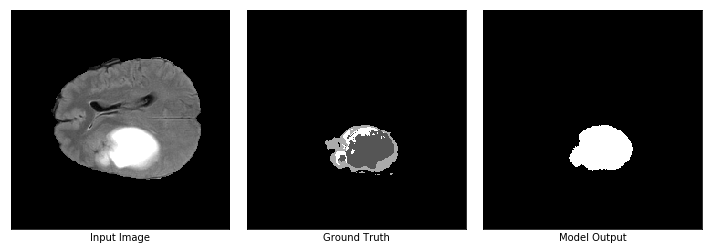

Steps: 2000, Loss:0.10039418190717697
Accurary: 0.9562152624130249
Dice coefficient: 0.9117030501365662
Sensitivity: 0.9710300937996721
Specificity: 0.9887480647081784
Gradient min:-0.003077157773077488, max:0.003207448171451688
-----------<Summary for Epoch:3>------------
Mean Accuracy: 0.9833799004554749
Mean Dice coefficient: 0.6584818363189697
Mean Sensitivity: 0.9897916000826459
Mean Specificity: 0.9947659542102454
------------------------------------------------
Epochs  4




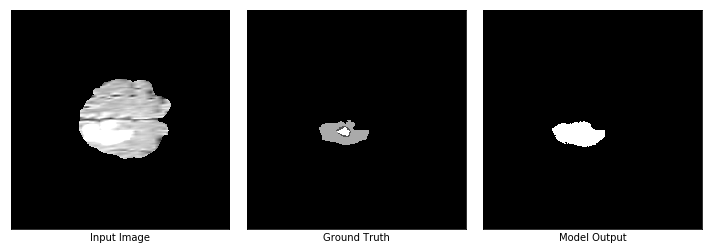

Steps: 2000, Loss:0.0379333533346653
Accurary: 0.9946701526641846
Dice coefficient: 0.9935623407363892
Sensitivity: 0.9969444445717592
Specificity: 0.998941780797513
Gradient min:-0.0019504382507875562, max:0.0017227050848305225
-----------<Summary for Epoch:4>------------
Mean Accuracy: 0.9857878684997559
Mean Dice coefficient: 0.7027515769004822
Mean Sensitivity: 0.991125156047096
Mean Specificity: 0.9956617364563993
------------------------------------------------
Epochs  5




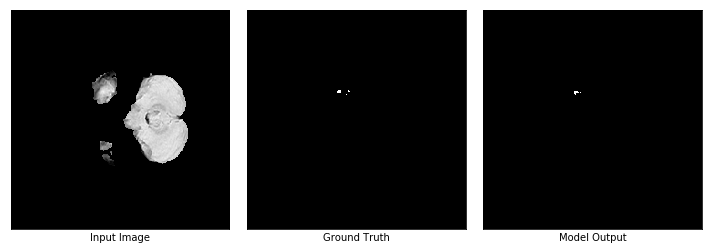

Steps: 2000, Loss:0.1055535152554512
Accurary: 0.9996874928474426
Dice coefficient: 0.9963889122009277
Sensitivity: 0.9998958333376736
Specificity: 0.9999648983541887
Gradient min:-0.00890249852091074, max:0.009575994685292244
-----------<Summary for Epoch:5>------------
Mean Accuracy: 0.9872642755508423
Mean Dice coefficient: 0.7304445505142212
Mean Sensitivity: 0.9919357918812156
Mean Specificity: 0.9962027920147167
------------------------------------------------
Epochs  6




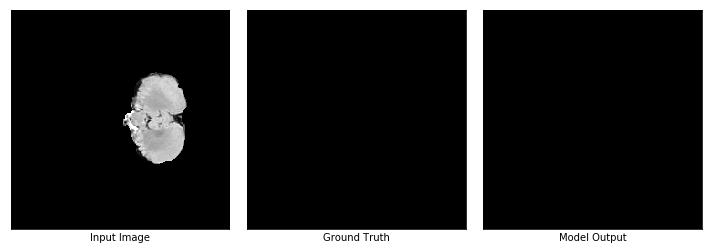

Steps: 2000, Loss:0.06516005098819733
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.00590902054682374, max:0.006573752965778112
-----------<Summary for Epoch:6>------------
Mean Accuracy: 0.9882681369781494
Mean Dice coefficient: 0.7498259544372559
Mean Sensitivity: 0.9924826963478955
Mean Specificity: 0.9965657068442126
------------------------------------------------
Epochs  7




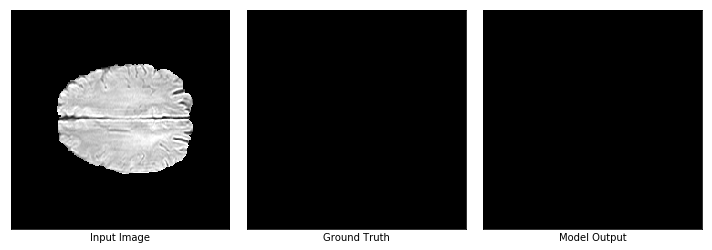

Steps: 2000, Loss:0.1255464404821396
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.0011459318920969963, max:0.001227318774908781
-----------<Summary for Epoch:7>------------
Mean Accuracy: 0.9889994263648987
Mean Dice coefficient: 0.7642362713813782
Mean Sensitivity: 0.9928779255763496
Mean Specificity: 0.9968264966292556
------------------------------------------------
Epochs  8




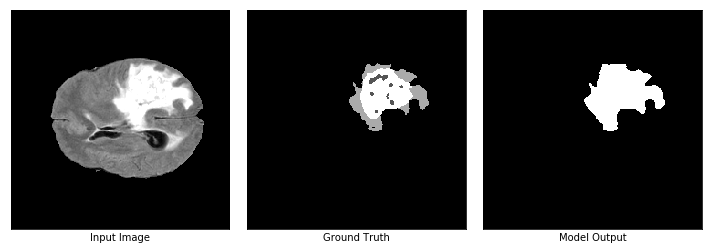

Steps: 2000, Loss:0.11485158652067184
Accurary: 0.9594270586967468
Dice coefficient: 0.9559841752052307
Sensitivity: 0.9624652793417245
Specificity: 0.9856755957654908
Gradient min:-0.001834214897826314, max:0.002859668806195259
-----------<Summary for Epoch:8>------------
Mean Accuracy: 0.9895593523979187
Mean Dice coefficient: 0.7755681276321411
Mean Sensitivity: 0.993178473298287
Mean Specificity: 0.9970234951879994
------------------------------------------------
Epochs  9




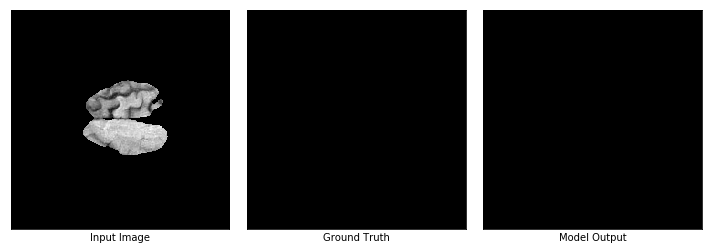

Steps: 2000, Loss:0.04661200940608978
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.00235003512352705, max:0.002181335585191846
-----------<Summary for Epoch:9>------------
Mean Accuracy: 0.9900027513504028
Mean Dice coefficient: 0.7847692370414734
Mean Sensitivity: 0.9934146569189886
Mean Specificity: 0.9971775445156648
------------------------------------------------
Epochs 10




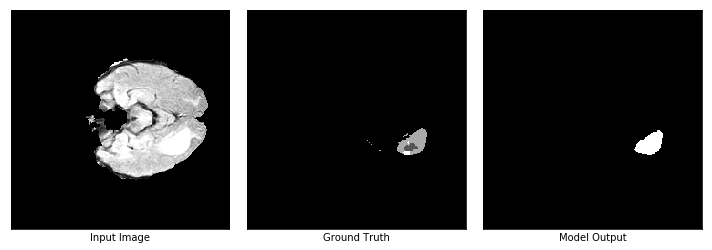

Steps: 2000, Loss:0.1289890855550766
Accurary: 0.9959895610809326
Dice coefficient: 0.989776074886322
Sensitivity: 0.9977719908335745
Specificity: 0.9992360740270041
Gradient min:-0.008440103381872177, max:0.006529922131448984
-----------<Summary for Epoch:10>------------
Mean Accuracy: 0.9903639554977417
Mean Dice coefficient: 0.792410671710968
Mean Sensitivity: 0.9936058399188735
Mean Specificity: 0.9973015452831251
------------------------------------------------
Epochs 11




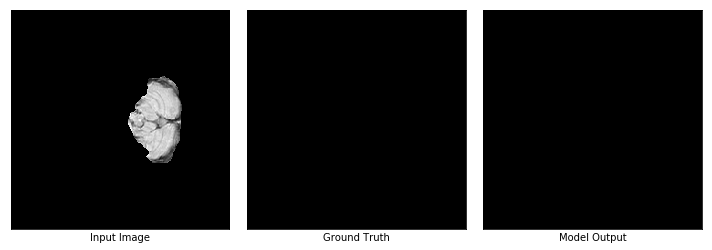

Steps: 2000, Loss:0.09068838506937027
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.001870910287834704, max:0.002033002907410264
-----------<Summary for Epoch:11>------------
Mean Accuracy: 0.990665078163147
Mean Dice coefficient: 0.7989007830619812
Mean Sensitivity: 0.9937642968524213
Mean Specificity: 0.9974036929095514
------------------------------------------------
Epochs 12




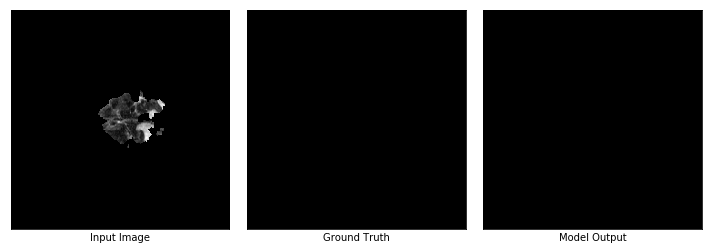

Steps: 2000, Loss:0.16093109548091888
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.00723074609413743, max:0.007322638761252165
-----------<Summary for Epoch:12>------------
Mean Accuracy: 0.9909203052520752
Mean Dice coefficient: 0.8044918775558472
Mean Sensitivity: 0.9938976656215719
Mean Specificity: 0.9974892661040599
------------------------------------------------
Epochs 13




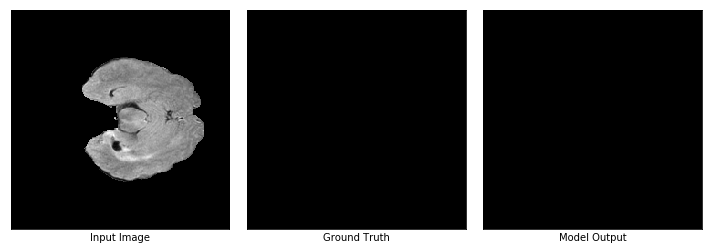

Steps: 2000, Loss:0.025967275723814964
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.0027809948660433292, max:0.003379911882802844
-----------<Summary for Epoch:13>------------
Mean Accuracy: 0.9911401271820068
Mean Dice coefficient: 0.8094477653503418
Mean Sensitivity: 0.994011913612973
Mean Specificity: 0.9975621500701656
------------------------------------------------
Epochs 14




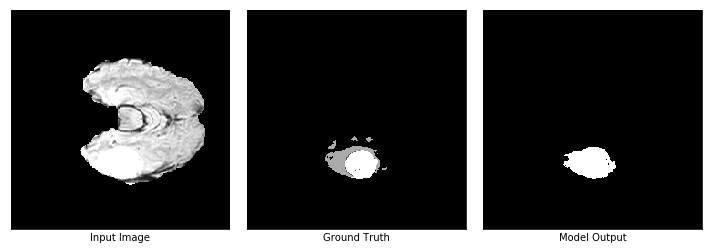

Steps: 2000, Loss:0.13665612041950226
Accurary: 0.9797569513320923
Dice coefficient: 0.9450908303260803
Sensitivity: 0.9833043988437982
Specificity: 0.9939136246695717
Gradient min:-0.004670108202844858, max:0.00423041358590126
-----------<Summary for Epoch:14>------------
Mean Accuracy: 0.9913303852081299
Mean Dice coefficient: 0.8137883543968201
Mean Sensitivity: 0.9941102910751622
Mean Specificity: 0.9976247761988285
------------------------------------------------
Epochs 15




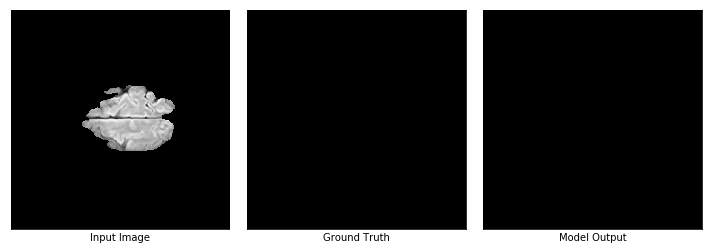

Steps: 2000, Loss:0.11971962451934814
Accurary: 1.0
Dice coefficient: 1.0
Sensitivity: 1.0
Specificity: 1.0
Gradient min:-0.001550259068608284, max:0.0020416697952896357


KeyboardInterrupt: 

In [7]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label,img_seg)
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [8]:
Unet.save_weights('/home/kevinteng/Desktop/model_weights/Unet_{}.h5'.format(ver))

---

# Validation 

In [ ]:
def val_fn(image, label):
    Unet.load_weights('/home/kevinteng/Desktop/model_weights/Unet_{}.h5'.format(ver))
    Unet.trainable = False
    model_output = Unet(image)
    loss = xent(label, model_output)
    return model_output, loss

In [ ]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/LGG/'

steps = 1
acc_list = []
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    dc_app = []
    sens_app = []
    spec_app = []
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        label = imgs[:,:,:,-1]
        label = tf.where(label==4,3,label)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #validation function 
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        dc_list, sens_list, spec_list =compute_metric(label,img_seg)
        #append
        acc_list.append(acc)
        dc_app.append(dc_list)
        sens_app.append(sens_list)
        spec_app.append(spec_list)
        #output
        if steps%100==0:
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            input_img = [image[0,:,:,0], label[0], img_seg[0]]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accuracy: {}".format(acc_stp))
            print("Dice coefficient: {}".format(dc_list))
            print("Sensitivity: {}".format(sens_list))
            print("Specificity: {}".format(spec_list))
        steps+=1
    mean_dc = np.mean(np.array(dc_app),0)
    mean_sens = np.mean(np.array(sens_app),0)
    mean_spec = np.mean(np.array(spec_app),0)
    print("Mean Accuracy: {}".format(np.mean(acc_list)))
    print("Mean Dice coefficient: {}".format(mean_dc))
    print("Mean Sensitivity: {}".format(mean_sens))
    print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [ ]:
Unet.summary()